In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import gym
import numpy as np
from collections import deque

# Set up environment
env = gym.make('CartPole-v1')

# Hyperparameters
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128
lr = 0.001
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 10
memory_size = 10000
num_episodes = 500


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize the Q-network and target network
policy_net = QNetwork(state_dim, action_dim)
target_net = QNetwork(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = deque(maxlen=memory_size)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def store_experience(memory, experience):
    memory.append(experience)

def sample_experience(memory, batch_size):
    experiences = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*experiences)
    return torch.tensor(states, dtype=torch.float32), \
           torch.tensor(actions), \
           torch.tensor(rewards, dtype=torch.float32), \
           torch.tensor(next_states, dtype=torch.float32), \
           torch.tensor(dones, dtype=torch.float32)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def train_dqn():
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = policy_net(state_tensor).argmax().item()

            next_state, reward, done, _ = env.step(action)
            store_experience(memory, (state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) >= batch_size:
                # Sample mini-batch from replay buffer
                states, actions, rewards, next_states, dones = sample_experience(memory, batch_size)

                # Compute current Q-values
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                # Compute loss and optimize the network
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Update target network
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        episode_rewards.append(total_reward) # Append to the correct list
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return episode_rewards # Return the list of rewards

rewards = train_dqn()


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-3-e3423bfbf010>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(states, dtype=torch.float32), \


Episode 1/500, Total Reward: 12.0, Epsilon: 0.995
Episode 2/500, Total Reward: 12.0, Epsilon: 0.990
Episode 3/500, Total Reward: 19.0, Epsilon: 0.985
Episode 4/500, Total Reward: 28.0, Epsilon: 0.980
Episode 5/500, Total Reward: 29.0, Epsilon: 0.975
Episode 6/500, Total Reward: 21.0, Epsilon: 0.970
Episode 7/500, Total Reward: 17.0, Epsilon: 0.966
Episode 8/500, Total Reward: 17.0, Epsilon: 0.961
Episode 9/500, Total Reward: 13.0, Epsilon: 0.956
Episode 10/500, Total Reward: 19.0, Epsilon: 0.951
Episode 11/500, Total Reward: 19.0, Epsilon: 0.946
Episode 12/500, Total Reward: 29.0, Epsilon: 0.942
Episode 13/500, Total Reward: 20.0, Epsilon: 0.937
Episode 14/500, Total Reward: 27.0, Epsilon: 0.932
Episode 15/500, Total Reward: 22.0, Epsilon: 0.928
Episode 16/500, Total Reward: 28.0, Epsilon: 0.923
Episode 17/500, Total Reward: 59.0, Epsilon: 0.918
Episode 18/500, Total Reward: 14.0, Epsilon: 0.914
Episode 19/500, Total Reward: 14.0, Epsilon: 0.909
Episode 20/500, Total Reward: 60.0, Epsi

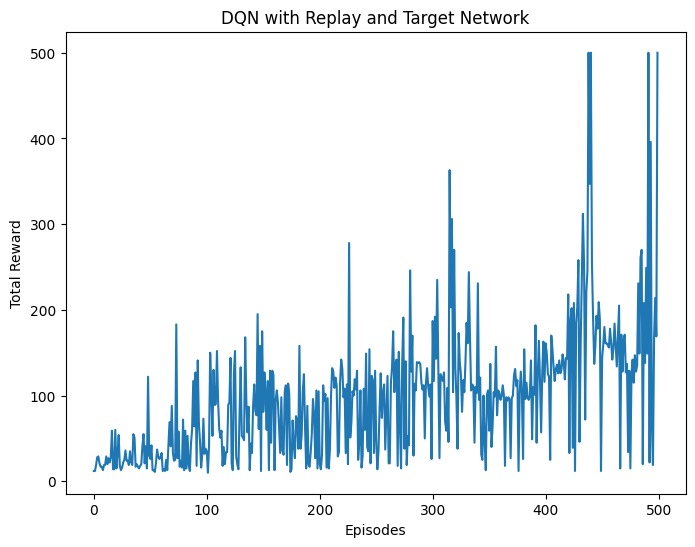

In [5]:
import matplotlib.pyplot as plt

# Plot the rewards
plt.figure(figsize=(8, 6))
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('DQN with Replay and Target Network')
plt.show()


In [6]:
def train_dqn_no_replay():
    epsilon = epsilon_start
    rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = policy_net(state_tensor).argmax().item()

            next_state, reward, done, _ = env.step(action)
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Compute current Q-values
            q_values = policy_net(state_tensor).gather(1, torch.tensor([[action]]))

            # Compute target Q-values
            with torch.no_grad():
                next_q_values = target_net(next_state_tensor).max(1)[0]
                target_q_values = reward + gamma * next_q_values * (1 - done)

            # Compute loss and optimize the network
            loss = nn.MSELoss()(q_values, target_q_values.unsqueeze(0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            state = next_state
            total_reward += reward

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        # Update target network
        if episode % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        rewards.append(total_reward)
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return rewards

rewards_no_replay = train_dqn_no_replay()


Episode 1/500, Total Reward: 19.0, Epsilon: 0.995
Episode 2/500, Total Reward: 12.0, Epsilon: 0.990
Episode 3/500, Total Reward: 19.0, Epsilon: 0.985
Episode 4/500, Total Reward: 21.0, Epsilon: 0.980
Episode 5/500, Total Reward: 22.0, Epsilon: 0.975
Episode 6/500, Total Reward: 22.0, Epsilon: 0.970
Episode 7/500, Total Reward: 16.0, Epsilon: 0.966
Episode 8/500, Total Reward: 13.0, Epsilon: 0.961
Episode 9/500, Total Reward: 13.0, Epsilon: 0.956
Episode 10/500, Total Reward: 18.0, Epsilon: 0.951
Episode 11/500, Total Reward: 12.0, Epsilon: 0.946
Episode 12/500, Total Reward: 35.0, Epsilon: 0.942
Episode 13/500, Total Reward: 12.0, Epsilon: 0.937
Episode 14/500, Total Reward: 29.0, Epsilon: 0.932
Episode 15/500, Total Reward: 25.0, Epsilon: 0.928
Episode 16/500, Total Reward: 11.0, Epsilon: 0.923
Episode 17/500, Total Reward: 37.0, Epsilon: 0.918
Episode 18/500, Total Reward: 16.0, Epsilon: 0.914
Episode 19/500, Total Reward: 16.0, Epsilon: 0.909
Episode 20/500, Total Reward: 40.0, Epsi

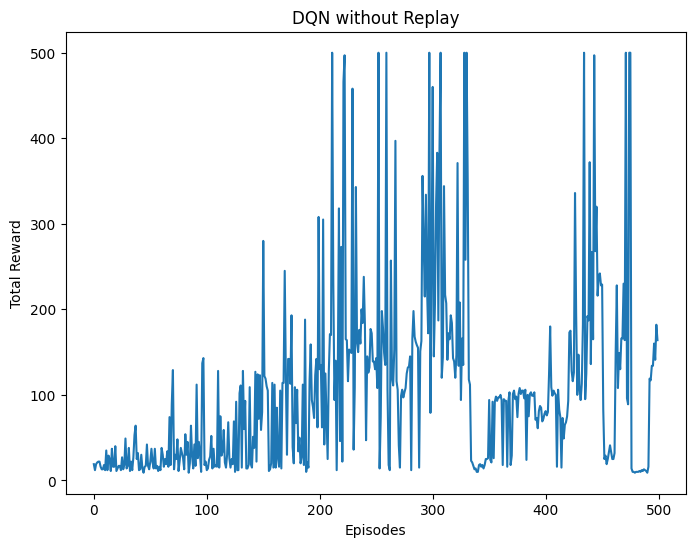

In [7]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.plot(rewards_no_replay)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('DQN without Replay')
plt.show()

In [8]:
def train_dqn_immediate_target_update():
    epsilon = epsilon_start
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = policy_net(state_tensor).argmax().item()

            next_state, reward, done, _ = env.step(action)
            store_experience(memory, (state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) >= batch_size:
                states, actions, rewards, next_states, dones = sample_experience(memory, batch_size)

                # Compute current Q-values
                q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    next_q_values = target_net(next_states).max(1)[0]
                    target_q_values = rewards + gamma * next_q_values * (1 - dones)

                # Compute loss and optimize the network
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Immediate update of the target network
                target_net.load_state_dict(policy_net.state_dict())

        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        episode_rewards.append(total_reward)
        print(f"Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    return episode_rewards

rewards_immediate_update = train_dqn_immediate_target_update()


Episode 1/500, Total Reward: 16.0, Epsilon: 0.995
Episode 2/500, Total Reward: 47.0, Epsilon: 0.990
Episode 3/500, Total Reward: 24.0, Epsilon: 0.985
Episode 4/500, Total Reward: 31.0, Epsilon: 0.980
Episode 5/500, Total Reward: 46.0, Epsilon: 0.975
Episode 6/500, Total Reward: 43.0, Epsilon: 0.970
Episode 7/500, Total Reward: 23.0, Epsilon: 0.966
Episode 8/500, Total Reward: 14.0, Epsilon: 0.961
Episode 9/500, Total Reward: 14.0, Epsilon: 0.956
Episode 10/500, Total Reward: 17.0, Epsilon: 0.951
Episode 11/500, Total Reward: 19.0, Epsilon: 0.946
Episode 12/500, Total Reward: 34.0, Epsilon: 0.942
Episode 13/500, Total Reward: 14.0, Epsilon: 0.937
Episode 14/500, Total Reward: 72.0, Epsilon: 0.932
Episode 15/500, Total Reward: 28.0, Epsilon: 0.928
Episode 16/500, Total Reward: 11.0, Epsilon: 0.923
Episode 17/500, Total Reward: 10.0, Epsilon: 0.918
Episode 18/500, Total Reward: 49.0, Epsilon: 0.914
Episode 19/500, Total Reward: 43.0, Epsilon: 0.909
Episode 20/500, Total Reward: 25.0, Epsi

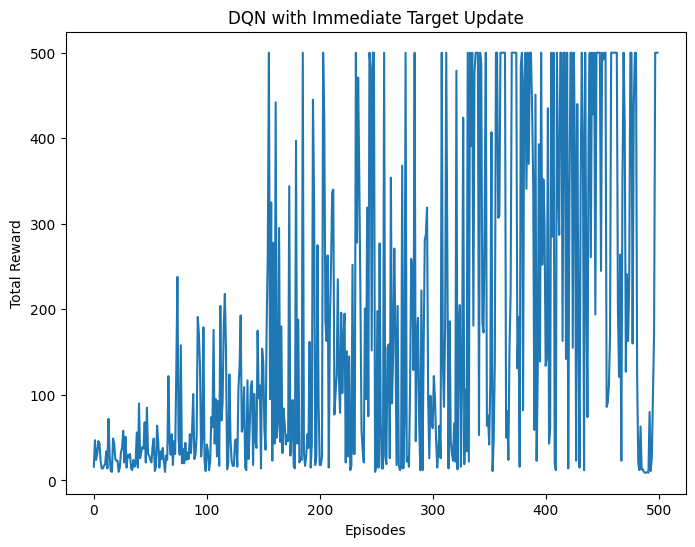

In [9]:
# Plot the rewards
plt.figure(figsize=(8, 6))
plt.plot(rewards_immediate_update)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('DQN with Immediate Target Update')
plt.show()

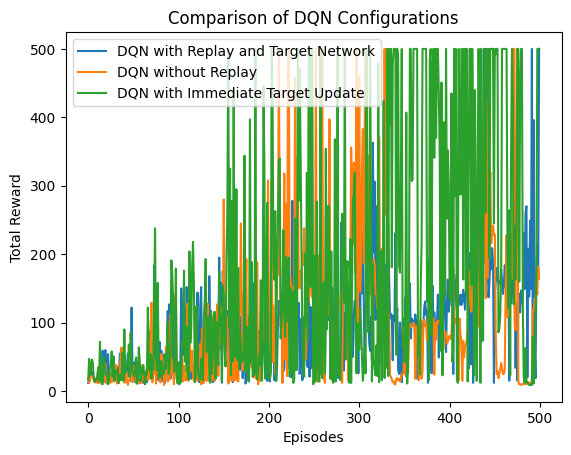

In [10]:
plt.plot(rewards, label='DQN with Replay and Target Network')
plt.plot(rewards_no_replay, label='DQN without Replay')
plt.plot(rewards_immediate_update, label='DQN with Immediate Target Update')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Comparison of DQN Configurations')
plt.legend()
plt.show()
